In [1]:
# import pyro
import pymc3 as pm

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from utils import load_data

In [3]:
mice = load_data()

In [4]:
# import torch
# from pyro.contrib import gp
# from pyro import distributions as dist

In [5]:
mouse2 = mice[2]['reads_abs_mean']
mouse2_t = mice[2]['times']

In [6]:
mouse2_pct = mouse2 / np.sum(mouse2, axis=0)

In [7]:
mouse2_t

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        6. ,  7. ,  8. ,  9. , 10. , 11. , 14. , 16. , 18. , 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 25. , 28. , 29. , 29.5, 30. , 30.5,
       31. , 31.5, 32. , 33. , 35. , 35.5, 36. , 36.5, 37. , 38. , 39. ,
       42. , 42.5, 43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 47. , 50. ,
       50.5, 51. , 51.5, 52. , 52.5, 53. , 54. , 57. , 57.5, 58. , 58.5,
       59. , 59.5, 60. , 60.5, 61. , 62. , 63. , 64. , 64.5])

In [8]:
mouse2_t.shape

(75,)

In [9]:
mouse2.shape

(202, 75)

In [10]:
mouse2.T.shape

(75, 202)

In [72]:
mouse2_t

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        6. ,  7. ,  8. ,  9. , 10. , 11. , 14. , 16. , 18. , 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 25. , 28. , 29. , 29.5, 30. , 30.5,
       31. , 31.5, 32. , 33. , 35. , 35.5, 36. , 36.5, 37. , 38. , 39. ,
       42. , 42.5, 43. , 43.5, 44. , 44.5, 45. , 45.5, 46. , 47. , 50. ,
       50.5, 51. , 51.5, 52. , 52.5, 53. , 54. , 57. , 57.5, 58. , 58.5,
       59. , 59.5, 60. , 60.5, 61. , 62. , 63. , 64. , 64.5])

In [74]:
mouse2_pct[1:6, :].shape

(5, 75)

In [139]:
X_dat = np.concatenate([mouse2_t.reshape(1,-1), mouse2_pct[1:2, :]], axis=0)
# X_dat = mouse2_t
y_dat = mouse2_pct[0,:]

# X = torch.tensor(X_dat, dtype=torch.float) # time-index bugs
# y = torch.tensor(y_dat, dtype=torch.float) # bug 0 over time


# kernel = gp.kernels.RBF(input_dim=1)
# kernel.set_prior("variance", dist.Uniform(torch.tensor(0.5), torch.tensor(1.5)))
# kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(1.0), torch.tensor(3.0)))
# gpr = gp.models.GPRegression(X, y, kernel)

In [135]:
# from pyro.infer.mcmc import HMC, MCMC

In [136]:
# hmc_kernel = HMC(gpr.model)
# mcmc_run = MCMC(hmc_kernel, num_samples=1000)
# posterior_ys_trace = []  # store lengthscale trace
# ls_name = "GPR/y"
# for trace, _ in mcmc_run._traces():
#     print(trace.nodes)
#     posterior_ys_trace.append(trace.nodes[ls_name]["value"])

In [140]:
X_dat.shape, y_dat.shape

((2, 75), (75,))

In [141]:
X_dat = X_dat.T
# X_dat = X_dat.reshape(-1,1)

In [142]:
X_dat.shape, y_dat.shape

((75, 2), (75,))

In [153]:
## PYMC3
import theano.tensor as tt

# 1 Dim Case
with pm.Model() as model:
    # priors on the covariance function hyperparameters
    l_time = pm.Uniform('l_time', 0, 10)
#     l_interact = pm.Uniform('l_interact', 0, 1)
    
    # uninformative prior on the function variance
    log_s2_f = pm.Uniform('log_s2_f', lower=-10, upper=5)
    s2_f = pm.Deterministic('s2_f', tt.exp(log_s2_f))
    
    # uninformative prior on the noise variance
    log_s2_n = pm.Uniform('log_s2_n', lower=-10, upper=5)
    s2_n = pm.Deterministic('s2_n', tt.exp(log_s2_n))

    # covariance functions for the function f and the noise
    f_cov = s2_f * pm.gp.cov.ExpQuad(input_dim=2, ls=l_time)
    
    gp = pm.gp.Marginal(cov_func=f_cov)
    
    marginal = gp.marginal_likelihood("marginal", X=X_dat, y=y_dat, noise=.1)

In [154]:
with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [log_s2_n, log_s2_f, l_time]
Sampling 4 chains:   0%|          | 0/6000 [00:00<?, ?draws/s]


ValueError: Not enough samples to build a trace.

In [127]:
pred, cov = gp.predict(X_dat)

In [128]:
pred.shape, cov.shape

((75,), (75, 75))

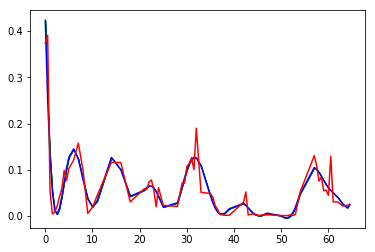

In [130]:
plt.plot(X_dat, pred, color='blue')
plt.plot(X_dat, y_dat, color='red')
plt.fill_between(mouse2_t, pred+cov.diagonal(), pred-cov.diagonal(), color='green', alpha=1)